# Deep Neural Network for regression to predict days_to_sell

## Environment setup and initialisation

In [11]:
import pandas as pd
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
import torch
import copy

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')


# Class for early stopping - code taken from Jeff Heatonhttps://www.youtube.com/watch?v=lS0vvIWiahU&pp=ygUZamVmZiBoZWF0b24gZWFybHkgc3RvcHBlcg%3D%3D
    
class EarlyStopper():
    def __init__(self, patience=5, min_delta=1e-2, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):

        #deal with inital call
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())

        # cases where loss has improved
        elif self.best_loss - val_loss >= self.min_delta:
            self.best_model = copy.deepcopy(model.state_dict())
            self.best_loss = val_loss
            self.counter = 0
            self.status = f"Found Improvement - Counter reset to {self.counter}!"

        else: 
            # increment counter
            self.counter += 1
            self.status = f"No Improvement in last {self.counter} epochs!"

            #if counter exceeded - no improvement
            if self.counter >= self.patience: 
                self.status = f"Early Stopping triggered after {self.counter} epochs!"
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
                return True
        return False



Using device: cuda

NVIDIA GeForce RTX 3080 Ti
Memory Usage:
Allocated: 1.0 GB
Cached:    3.8 GB


## Preprocessing

In [12]:
import pandas as pd
pd.set_option('display.max_columns', None)

# Read ds into dataframe

data_path = f"../data/rate_of_sale_may_2023.snappy.parquet"


data = pd.read_parquet(data_path)


data.head(3)

# explore data
data['first_retailer_asking_price'].head(1)

column_range = data['days_to_sell'].max() - data['days_to_sell'].min()


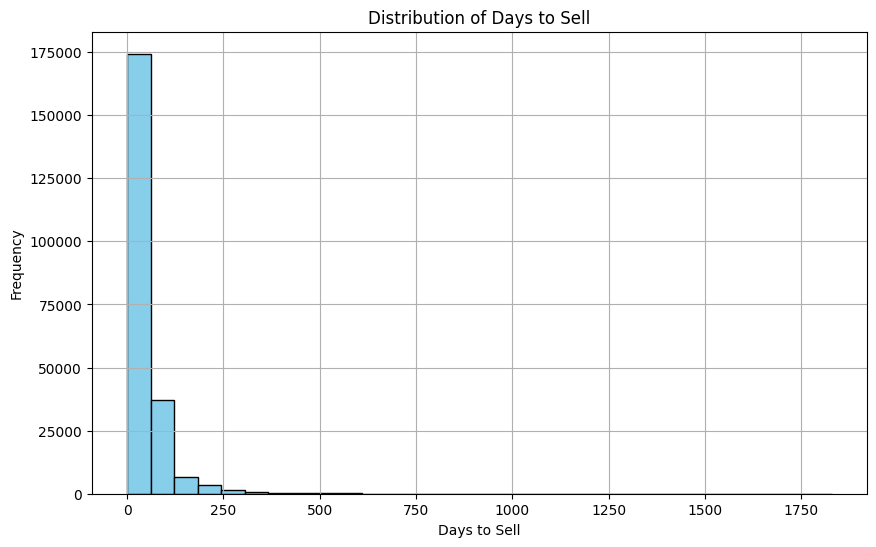

In [13]:
import matplotlib.pyplot as plt

days_to_sell = data['days_to_sell']

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(days_to_sell, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Days to Sell')
plt.xlabel('Days to Sell')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [16]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from datetime import datetime

features = ['reg_year',
            'make',
            'model',
            'body_type',
            'fuel_type',
            'transmission_type',
            'drivetrain',
            'colour',
            'price_indicator_rating',
            'postcode_area',
            'first_retailer_asking_price',
            'reviews_per_100_advertised_stock_last_12_months',
            'seats',
            'doors',
            'co2_emission_gpkm',
            'top_speed_mph',
            'zero_to_sixty_mph_seconds',
            'engine_power_bhp',
            'fuel_economy_wltp_combined_mpg',
            'battery_range_miles',
            'battery_usable_capacity_kwh',
            'length_mm',
            'boot_space_seats_up_litres',
            'insurance_group',
            'odometer_reading_miles',
            'adjusted_retail_amount_gbp',
            'predicted_mileage',
            'number_of_images',
            'advert_quality',
            #'percentage_through_year',
            'can_home_deliver',
            'manufacturer_approved',
            'segment'
            ]

target = 'days_to_sell'

# Dropping rows with missing target values
data_cleaned = data.dropna(subset=[target])


# Function to calculate percentage through the year
def percentage_through_year(date_str):

    date_obj = datetime.strptime(str(date_str), "%Y-%m-%d")
    day_of_year = date_obj.timetuple().tm_yday
    # Check if it's a leap year
    is_leap_year = date_obj.year % 4 == 0 and (date_obj.year % 100 != 0 or date_obj.year % 400 == 0)
    
    total_days_in_year = 366 if is_leap_year else 365
    percentage = (day_of_year / total_days_in_year)
    
    return float(percentage)

# Function to calculate registration year from plate
def plate_to_year(identifier):
    if not identifier:
        return identifier
    
    # Direct mapping of first letter to registration year
    letter_year_map = {
      'A': 1983, 'B': 1984, 'C': 1985, 'D': 1986, 'E': 1987, 
      'F': 1988, 'G': 1989, 'H': 1990, 'J': 1991, 'K': 1992, 
      'L': 1993, 'M': 1994, 'N': 1995, 'P': 1996, 'R': 1997, 
      'S': 1998, 'T': 1999, 'V': 1999, 'W': 2000, 'X': 2000,
      'Y': 2001
    }
    
    # Check if the identifier is a letter or a number
    if isinstance(identifier, str) and identifier.upper() in letter_year_map:
      # Handle letter-based registration year
      return letter_year_map[identifier.upper()]
    elif isinstance(identifier, int) or (isinstance(identifier, str) and identifier.isdigit()):
      # Convert string digits to integer if necessary
      plate_year = int(identifier)
      # Handle number-based registration year
      if plate_year < 50:
          # For plates issued from March to August
          return 2000 + plate_year
      else:
          # For plates issued from September to February of the following year
          return 1950 + plate_year
    else:
      print(identifier)
      raise ValueError("Invalid identifier in 'plate_to_year' function.")


# Apply the function to the "first_date_listed" column
#data_cleaned['percentage_through_year'] = data_cleaned['first_date_seen'].apply(percentage_through_year)

# Apply the function to the "plate" column
data_cleaned['reg_year'] = data_cleaned['plate'].apply(plate_to_year)
   

# Separating features and target
X_df = data_cleaned[features]
y_df = data_cleaned[target]

# Split up categorical/numerical features
categorical_features = ['make',
                        'model',
                        'body_type',
                        'fuel_type',
                        'transmission_type',
                        'drivetrain',
                        'colour',
                        'price_indicator_rating',
                        'postcode_area',
                        'segment',
                        ]

numerical_features = [
                      'reg_year',
                      'first_retailer_asking_price',
                      'reviews_per_100_advertised_stock_last_12_months',
                      'seats',
                      'doors',
                      'co2_emission_gpkm',
                      'top_speed_mph',
                      'zero_to_sixty_mph_seconds',
                      'engine_power_bhp',
                      'fuel_economy_wltp_combined_mpg',
                      'battery_range_miles',
                      'battery_usable_capacity_kwh',
                      'length_mm',
                      'boot_space_seats_up_litres',
                      'insurance_group',
                      'odometer_reading_miles',
                      'adjusted_retail_amount_gbp',
                      'predicted_mileage',
                      'number_of_images',
                      'advert_quality',
                      #'percentage_through_year'
                      ]

binary_features = ['can_home_deliver', 'manufacturer_approved']

# Preprocessing pipelines for numerical/categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore',sparse_output=False))])

# Define preprocessing for specific columns
column_transformer = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features),
        ('binary', 'passthrough', binary_features)
    ])

X = column_transformer.fit_transform(X_df)

Y = y_df.values

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


## Trying Random Forest Model for comparison

In [7]:
from sklearn.ensemble import RandomForestRegressor

# Creating a pipeline with preprocessing and model

rf_model = Pipeline(steps=[('regressor', RandomForestRegressor(n_estimators=100, random_state=42))])

# Training the model
rf_model.fit(x_train, y_train)

# We'll evaluate the model's performance next
rf_model

Pipeline(steps=[('regressor', RandomForestRegressor(random_state=42))])

In [44]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Making predictions on the test set
y_pred = rf_model.predict(x_test)

# Calculating the Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

# Calculating the Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Calculating the R-squared value
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")

NameError: name 'rf_model' is not defined

## Building NN model

In [17]:
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.autograd import Variable
from sklearn import preprocessing
from torch.utils.data import DataLoader, TensorDataset
import tqdm
import time

class Net(nn.Module):
    def __init__(self, in_count, out_count):
        super(Net, self).__init__()
        print(f"incount: {in_count}")
        hidden_neurons = [800, 400, 200, 100, 50]
        self.fc1 = nn.Linear(in_count, hidden_neurons[0])
        self.fc2 = nn.Linear(hidden_neurons[0], hidden_neurons[1])
        self.fc3 = nn.Linear(hidden_neurons[1], hidden_neurons[2])
        self.fc4 = nn.Linear(hidden_neurons[2], hidden_neurons[3])
        self.fc5 = nn.Linear(hidden_neurons[3], hidden_neurons[4])
        self.fc6 = nn.Linear(hidden_neurons[4], out_count)

    def forward(self, x):
        # Apply activation function 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        # Output layer
        x = self.fc6(x)
        return x
    

# Np -> Torch Tensor
    
x_train_tensor = torch.Tensor(x_train).float()
y_train_tensor = torch.Tensor(y_train).float()

x_test_tensor = torch.Tensor(x_test).float().to(device)
y_test_tensor = torch.Tensor(y_test).float().to(device)

# Create datasets

BATCH_SIZE = 32

dataset_train = TensorDataset(x_train_tensor, y_train_tensor)
dataloader_train = DataLoader(dataset_train,batch_size=BATCH_SIZE, shuffle=True) 

dataset_test = TensorDataset(x_test_tensor, y_test_tensor)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True) 

# define model
nn_model = Net(X.shape[1],1).to(device)

# define loss function

loss_fn = nn.MSELoss()

# define optimizer

optimizer = torch.optim.Adam(nn_model.parameters())

# Define early stop

es = EarlyStopper()

# Init Run

epoch = 0
done = False

while epoch < 1000 and not done:
    epoch += 1
    steps = list(enumerate(dataloader_train))
    pbar = tqdm.tqdm(steps)
    nn_model.train()

    for i, (x_batch, y_batch) in pbar:
        y_batch_pred = nn_model(x_batch.to(device)).flatten()
        loss = loss_fn(y_batch_pred, y_batch.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss, current = loss.item(), (i + 1) * len(x_batch)

        if i == len(steps) - 1:
            nn_model.eval()
            pred = nn_model(x_test_tensor).flatten()
            vloss = loss_fn(pred, y_test_tensor)

            if es(nn_model, vloss): done = True
            pbar.set_description(f"Epoch: {epoch}, tloss: {loss}, vloss: {vloss:>7f}, EStop:[{es.status}]")
        else:
            pbar.set_description(f"Epoch: {epoch}, tloss {loss:}")




incount: 1141


Epoch: 1, tloss: 3645.6064453125, vloss: 5519.123535, EStop:[]: 100%|██████████| 5614/5614 [00:17<00:00, 316.15it/s]
Epoch: 2, tloss: 1418.3275146484375, vloss: 4793.564941, EStop:[Found Improvement - Counter reset to 0!]: 100%|██████████| 5614/5614 [00:17<00:00, 325.57it/s]
Epoch: 3, tloss: 994.9817504882812, vloss: 5526.207520, EStop:[No Improvement in last 1 epochs!]: 100%|██████████| 5614/5614 [00:17<00:00, 325.96it/s]
Epoch: 4, tloss: 1226.0, vloss: 3956.773682, EStop:[Found Improvement - Counter reset to 0!]: 100%|██████████| 5614/5614 [00:17<00:00, 321.60it/s]
Epoch: 5, tloss: 2760.622314453125, vloss: 3045.007568, EStop:[Found Improvement - Counter reset to 0!]: 100%|██████████| 5614/5614 [00:17<00:00, 322.46it/s]
Epoch: 6, tloss: 1504.5538330078125, vloss: 3588.549805, EStop:[No Improvement in last 1 epochs!]: 100%|██████████| 5614/5614 [00:17<00:00, 326.43it/s]
Epoch: 7, tloss: 3324.572998046875, vloss: 10340.332031, EStop:[No Improvement in last 2 epochs!]: 100%|██████████| 

In [18]:
from sklearn import metrics

# Making predictions
pred = nn_model(x_test_tensor)

# Calculating Mean Squared Error (MSE)
mse = metrics.mean_squared_error(pred.cpu().detach().numpy(), y_test_tensor.cpu().detach().numpy())
print("Final score (MSE): {}".format(mse))

# Calculating Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Final score (RMSE): {}".format(rmse))

Final score (MSE): 3045.007568359375
Final score (RMSE): 55.18158721923828


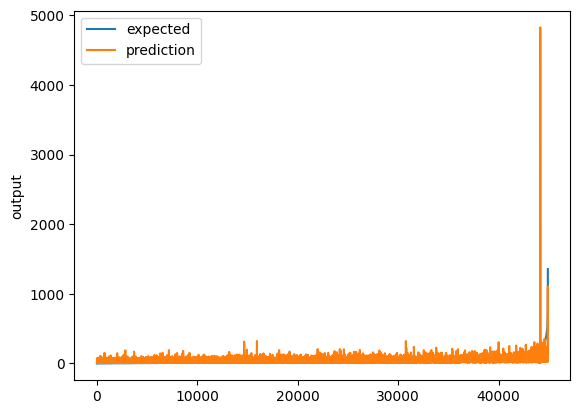

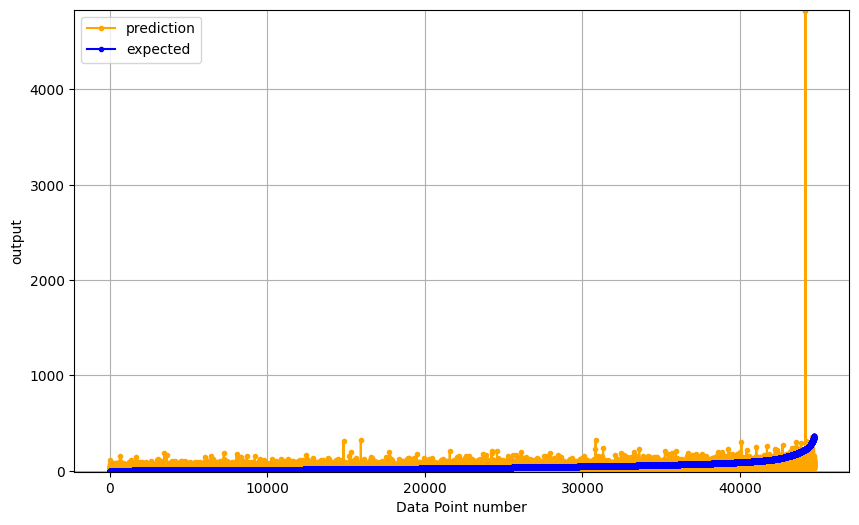

In [19]:
import matplotlib.pyplot as plt

def chart_regression_unfiltered(pred, y, sort=True):
    t = pd.DataFrame({'pred': pred, 'y': y.flatten()})
    if sort:
        t.sort_values(by=['y'], inplace=True)
    plt.plot(t['y'].tolist(), label='expected')
    plt.plot(t['pred'].tolist(), label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()


def chart_regression_filtered(pred, y, sort=True, max_days=365, bins=100):
    t = pd.DataFrame({'pred': pred, 'y': y.flatten()})
    
    # Remove outliers above max_days
    t = t[t['y'] <= max_days]

    if sort:
        t.sort_values(by=['y'], inplace=True)
    
    # Plotting with a finer resolution
    plt.figure(figsize=(10, 6))
    plt.plot(t['pred'].tolist(), label='prediction', marker='o', markersize=3, linestyle='-', color='orange')
    plt.ylabel('output')
    plt.xlabel('Data Point number')
    
    # Setting y-axis limits
    plt.ylim(min(t['pred'].min(), t['y'].min()) - 10, max(t['pred'].max(), t['y'].max()) + 10)
    
    plt.plot(t['y'].tolist(), label='expected', marker='o', markersize=3, linestyle='-', color='blue')
    
    plt.legend()
    plt.grid(True)
    plt.show()

pred_x = pred.cpu().detach().numpy().flatten()
pred_y = y_test_tensor.cpu().detach().numpy()
chart_regression_unfiltered(pred_x, pred_y)
chart_regression_filtered(pred_x, pred_y)

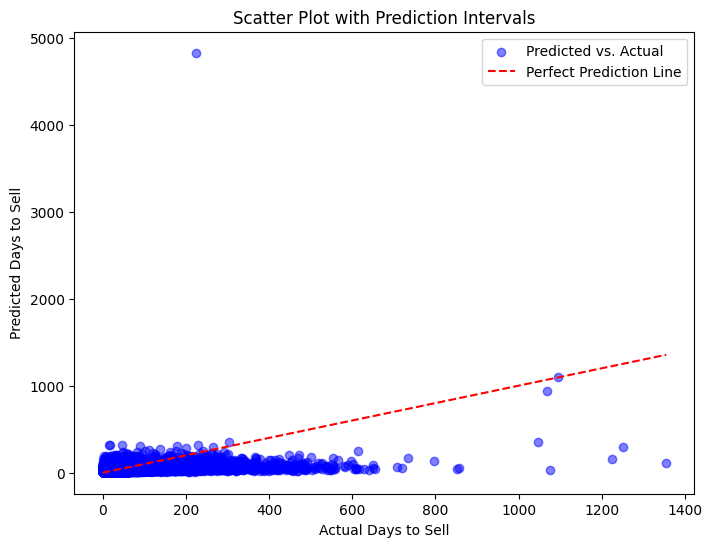

In [20]:
def scatter_with_prediction_intervals(y_test, y_pred):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, color='blue', alpha=0.5, label='Predicted vs. Actual')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction Line')
    plt.title('Scatter Plot with Prediction Intervals')
    plt.xlabel('Actual Days to Sell')
    plt.ylabel('Predicted Days to Sell')
    plt.legend()
    plt.show()

pred_x = pred.cpu().detach().numpy().flatten()
pred_y = y_test_tensor.cpu().detach().numpy()
scatter_with_prediction_intervals(pred_y, pred_x)